In [ ]:
# DR2_5918299904067162240.ipynb
#
# Author: Alexander J Mustill, 2018
# Lund Observatory, Department of Astronomy & Theoretical Physics, 
# Lund University, Box 43, SE-221 00 Lund, Sweden
#
# If you make use of this code, please cite Mustill, Davies & Lindegren (2018, A&A submitted, https://arxiv.org/abs/1805.11638).
#
# Please direct any queries to Alexander Mustill, alex@astro.lu.se
#
# This script queries one particular object (DR2 5918299904067162240 by default), 
# performs MC simulations of the source and lens trajectories, and generates diagnostic 
# plots of the sky motion, magnification, duration and other key lensing parameters.

In [1]:
import datetime
import math

import astropy.units as u
import astropy.time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astropy.io.votable import parse_single_table
from astropy.io import ascii

from gaiaDR2 import Gaia
#import ../gaiaHeidelberg as Gaia

from microlensing import magnification, REinstein, get_alignments, net_magnification
import photometry

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
vot_file = 'DR2_5918299904067162240.vot'
stars = parse_single_table(vot_file)

#make an alias for concision
s = stars.array

#Earth = ascii.read("EarthEphemeris.txt",format="csv",fast_reader=False,header_start=20,data_start=23,data_end=1024)
#Earth = ascii.read("EarthEphemerisNt2000.txt",format="csv",fast_reader=False,header_start=20,
#                   data_start=23,data_end=2024)
#Earth = ascii.read("EarthEphemerisNt4000.txt",format="csv",fast_reader=False,header_start=20,
#                   data_start=23,data_end=4024)
Earth = ascii.read("EarthEphemerisNt8000.txt",format="csv",fast_reader=False,header_start=20,
                   data_start=23,data_end=8024)
#Earth = ascii.read("EarthEphemerisNt16000.txt",format="csv",fast_reader=False,header_start=20,
#                   data_start=23,data_end=16024)

Sol = ascii.read("SolRADecNt8000.txt",format='fixed_width_no_header',
                 names=('date','time','RAhh','RAmm','RAss','Decsign','Decdd','Decmm','Decss'),
                 col_starts=(1,13,30,33,36,42,43,46,49),data_start=53,data_end=8054)
RASol = Sol['RAhh']*15 + Sol['RAmm']*15/60.0 + Sol['RAss']*15/3600.0
DecSol = ((Sol['Decdd'] + Sol['Decmm']/60.0 + Sol['Decss']/3600.0) * 
          ((Sol['Decsign'] == '+')*1 - (Sol['Decsign'] == '-')*1))
PosSol = SkyCoord(RASol*u.deg,DecSol*u.deg,frame='icrs')
#WOW sexagesimal is annoying

source_index = 5
#seed the generator for reproducibility
np.random.seed(87654)
nt = 8001
#have to set the lens mass manually
#Mstar = 1.0
#(We do it from photometry now)

In [3]:
interesting = [0]

In [4]:
deltaT = 20 #time we're interested in [yr]

Nclose = np.zeros(len(s)) #number of neighbours within search radius (INCLUDING SELF)
radius = []
results = []

In [5]:
t1 = datetime.datetime.now()

#for i in range(len(stars.array)):

for i in range(len(s)):

#    uncomment the following if you have pre-generated the list of interesting stars
    if i in interesting:

#    if True:

# we have to query by an object's position (not Gaia ID) because of the SIMBAD lookup "feature"
# also we need to pretend the frame is FK5 not ICRS -- seems to be a bug with astroquery.gaia
#        coord = SkyCoord(ra=s[i]['ra'],dec=s[i]['dec'],unit=(u.degree, u.degree),frame='icrs')

#compute total PM (cos delta conversion is already performed in the datafiles)
        pm = np.sqrt(s[i]['pmra']**2 + s[i]['pmdec']**2) / (1000*3600) # deg/yr

#search radius = annual parallactic motion plus PM over timescale of interest
        radius.append(Quantity(pm*deltaT + 2*s[i]['parallax']/(1000*3600),unit=u.deg))
        print('i = ',i)
#abandon using astroquery to generate the ADQL: it keeps screwing up the coordinates
        job = Gaia.launch_job_async("SELECT DISTANCE(POINT('ICRS',ra,dec), \
        POINT('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+")) AS dist, * \
        FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),\
        CIRCLE('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+","+str(radius[i].value)+"))=1 ORDER BY dist ASC")
        r = job.get_results()
    
        Nclose[i] = len(r)
        
        results.append(r)
    else:
        Nclose[i] = 1
        radius.append(None)
        results.append(None)
    
t2 = datetime.datetime.now()

print('Time elapsed: ',t2-t1)

i =  0
Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),         POINT('ICRS',269.66258508708955,-58.66025011801147)) AS dist, *         FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),        CIRCLE('ICRS',269.66258508708955,-58.66025011801147,0.005646592648306357))=1 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
Time elapsed:  0:00:00.542844


In [6]:
# calculate stellar parameters, mass estimate, HZ

if math.isnan(s[0]['a_g_val']):
    AG = 0
    AGm= 0
    AGp= 0
else:
    AG = s[0]['a_g_val']
    AGm= s[0]['a_g_percentile_lower']
    AGp= s[0]['a_g_percentile_upper']

if math.isnan(s[0]['teff_percentile_lower']):
    Mlens = [0.1,0.1,0.1]
    Llens = [photometry.MtoL(Mlens[0]),photometry.MtoL(Mlens[1]),photometry.MtoL(Mlens[2])]
else:
    Llens = [10**(photometry.logLBol(s[0]['phot_g_mean_mag'],s[0]['teff_percentile_lower'],s[0]['parallax'],AGm)),
             10**(photometry.logLBol(s[0]['phot_g_mean_mag'],s[0]['teff_val'],s[0]['parallax'],AG)),
             10**(photometry.logLBol(s[0]['phot_g_mean_mag'],s[0]['teff_percentile_upper'],s[0]['parallax'],AGp))]

    Mlens = [photometry.LtoM(Llens[0]),photometry.LtoM(Llens[1]),photometry.LtoM(Llens[2])]

Mstar = Mlens[1]

RHZ = [photometry.RHZ(Llens[0]),photometry.RHZ(Llens[1]),photometry.RHZ(Llens[2])]

if math.isnan(results[0][source_index]['parallax']):
    psource = 0
else:
    psource = results[0][source_index]['parallax']

RE_Final = [REinstein(Mlens[0],s[0]['parallax'],max([psource,0])),
            REinstein(Mlens[1],s[0]['parallax'],max([psource,0])),
            REinstein(Mlens[2],s[0]['parallax'],max([psource,0]))]

print('Lens luminosity: ',Llens,' LSol')
print('Lens mass:       ',Mlens,' MSol')
print('Lens HZ:         ',RHZ,' au')
print('Einstein radius: ',RE_Final,' mas')
print('                 ',RE_Final/s[0]['parallax'],' au')

#Note: because of the steep dependence of the bolometric correction on Teff at low temperatures, 
#the lower Teff can mean larger luminosities and masses

Lens luminosity:  [0.0007391356872579637, 0.0006776246853874626, 0.0006673885388235476]  LSol
Lens mass:        [0.10367490299416464, 0.10026750174703446, 0.09968222058897772]  MSol
Lens HZ:          [0.027187049991824485, 0.026031225199507277, 0.025833864186829418]  au
Einstein radius:  [6.627041440356509, 6.517228749087569, 6.498179736217506]  mas
                  [0.12686843 0.12476617 0.12440149]  au


In [7]:

time = np.linspace(0,deltaT,num=nt)

# only interested in alignments from start of this year
# this will also hopefully cut out the annoying duplicated sources
tStart = 3.0
earlyIndex = time < tStart
lateIndex = time >= tStart

raNom = [None]*len(s)
decNom = [None]*len(s)
dRASourceNom = [None]*len(s)
dDecSourceNom = [None]*len(s)
dRALensNom = [None]*len(s)
dDecLensNom = [None]*len(s)
DminNom = [None]*len(s)
Dmin2015Nom = [None]*len(s)

HasAClose = [False]*len(s)
R_E = [None]*len(s)
mag_factor = [None]*len(s)
mag_factor_net = [None]*len(s)

for i in range(len(s)):

    raNom[i] = s[i]['ra']*u.deg + s[i]['pmra']*time*u.mas/np.cos(np.radians(s[i]['dec']))
    decNom[i] = s[i]['dec']*u.deg + s[i]['pmdec']*time*u.mas

    if Nclose[i] > 1:
        dRASourceNom[i] = (results[i]['ra']-raNom[i][0])*np.cos(np.radians(results[i]['dec']))*3600
        dDecSourceNom[i] = (results[i]['dec']-decNom[i][0])*3600

        dRALensNom[i] = (raNom[i]-raNom[i][0])*np.cos(np.radians(decNom[i]))*3600
        dDecLensNom[i] = (decNom[i]-decNom[i][0])*3600

#Euclidean distance (neglect curvature for now)
        DminNom[i] = np.zeros(len(results[i]))
        Dmin2015Nom[i] = np.zeros(len(results[i]))
        R_E[i] = np.zeros(len(results[i]))
        mag_factor[i] = np.zeros([len(results[i]),nt])
        mag_factor_net[i] = np.zeros([len(results[i]),nt])
        
        for j in range(len(results[i])):
            
            # set NaN fields to 0 for pm, parallax and their errors
            for k in ['parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error',
                     'ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr',
                     'dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr',
                     'pmra_pmdec_corr','parallax_pmra_corr',
                     'parallax_pmdec_corr']:
            
                if math.isnan(results[i][j][k]):
                    results[i][j][k] = 0
                    
            # compute the Einstein radius given the source and lens distance (set source parallax to 0 if -ve)
            R_E[i][j] = REinstein(Mstar,s[i]['parallax'],max([results[i][j]['parallax'],0]))
            
            distance2 = (dRASourceNom[i][j]-dRALensNom[i].value)**2 + (dDecSourceNom[i][j]-dDecLensNom[i].value)**2
            distance = np.sqrt(distance2)
            mag_factor[i][j] = magnification(distance,R_E[i][j]/1000)
            mag_factor_net[i][j] = net_magnification(s[i]['phot_g_mean_mag'],results[i][j]['phot_g_mean_mag'],
                                                    mag_factor[i][j])
            
            Dmin2015Nom[i][j] = np.min(distance[earlyIndex])
            DminNom[i][j] = np.min(distance[lateIndex])
            if HasAClose[i] == False:
                if DminNom[i][j] < 1 and DminNom[i][j] < Dmin2015Nom[i][j]:
                    HasAClose[i] = True

        print(i,DminNom[i])

0 [ 3.03348428  3.62283822  3.85040706  2.17439695 13.94216731  0.04719499
 16.75979728 13.96247739 20.65191214 15.55431989 21.48149539]


/Users/alexander/research/gaia/microlensing/DR2/github/microlensing.py:9: RuntimeWarning: divide by zero encountered in true_divide
  u = dist/R_E
/Users/alexander/research/gaia/microlensing/DR2/github/microlensing.py:9: RuntimeWarning: invalid value encountered in true_divide
  u = dist/R_E
/Users/alexander/research/gaia/microlensing/DR2/github/microlensing.py:11: RuntimeWarning: invalid value encountered in true_divide
  return (u**2 + 2) / (u*np.sqrt(u**2+4))
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Warning: converting a masked element to nan.
/Users/alexander/anaconda/envs/astropy/lib/python3.6/site-packages/ipykernel_lau

In [8]:

# only interested in alignments from start of this year
# this will also hopefully cut out the annoying duplicated sources
tStart = 3.0
earlyIndex = time < tStart
lateIndex = time >= tStart

if Nclose[i] > 1:
    
    # recentre to nominal lens location
    dRASource = (results[i]['ra'] - s[i]['ra'])*np.cos(np.radians(s[i]['dec']))*3600
    dDecSource = (results[i]['dec'] - s[i]['dec'])*3600
    
    # get alignments, distances, magnifications

    lensNom = np.zeros([len(results[i]),2,nt])
    sourceNom = np.zeros([len(results[i]),2,nt])
    distanceNom = []
    R_ENom  = []
    mag_factorNom = []
    mag_factor_netNom  = []
    
    DminNom[i] = np.zeros(len(results[i]))
    Dmin2015Nom[i] = np.zeros(len(results[i]))
    
    for j in range(len(results[i])):
    
        lens, source, distance, R_E, mag_factor = get_alignments(np.array([[0,0,s[i]['pmra'],s[i]['pmdec'],
                                                                            s[i]['parallax']]]),
                                                                 np.array([[dRASource[j],dDecSource[j],
                                                                            results[i][j]['pmra'],
                                                                            results[i][j]['pmdec'],
                                                                            results[i][j]['parallax']]]),
                                                                 time,Mstar,Earth,s[i]['ra'],s[i]['dec'])
        
        lensNom[j,:,:] = lens
        sourceNom[j,:,:] = source
        distanceNom.append(distance)
        R_ENom.append(R_E)
        mag_factor_netNom.append(net_magnification(s[i]['phot_g_mean_mag'],results[i][j]['phot_g_mean_mag'],
                                                    mag_factor))
        mag_factorNom.append(mag_factor)
    
        Dmin2015Nom[i][j] = np.min(distance[:,earlyIndex])
        DminNom[i][j] = np.min(distance[:,lateIndex])
        if HasAClose[i] == False:
            if DminNom[i][j] < 1000 and DminNom[i][j] < Dmin2015Nom[i][j]:
                HasAClose[i] = True

    print(i,DminNom[i])

0 [0.00000000e+00 3.65313334e+00 3.88783332e+00 2.12116146e+00
 1.39332600e+01 6.74993277e-03 1.67809292e+01 1.39139029e+01
 2.06556401e+01 1.55257077e+01 2.14752303e+01]


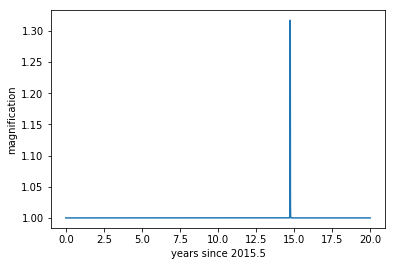

In [9]:
plt.plot(time,mag_factorNom[source_index][0][:])
plt.xlabel('years since 2015.5')
plt.ylabel('magnification')
#plt.savefig(fname='mag.pdf')
plt.show()

0 Gaia DR2  5918299904067162240 N sources:  11
Source               V mag                 Dmin
5918299904067162240 14.911963 0.0
5918299908359752960 19.35156 3.653133342438641
5918299908359753088 19.190987 3.8878333207395865
5918299908359751424 19.084717 2.1211614625158735
5918299904067711360 16.486412 13.93325995716875
5918299908365843840 13.903836 0.0067499327735941785
5918299908362201472 20.387114 16.78092921659164
5918299702206881024 20.703568 13.91390286805246
5918299908359757440 19.95878 20.655640076849405
5918299904064912896 19.635935 15.525707740060831
5918299904064673280 15.034772 21.475230334301944
 
 


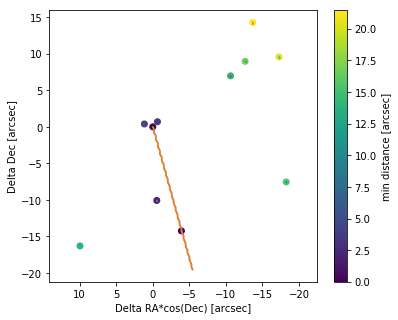

In [10]:
i = 0

print(i,'Gaia DR2 ',s[i]['source_id'],'N sources: ',len(results[i]))
print('Source               V mag                 Dmin')
#print(s[i]['source_id'],s[i]['phot_g_mean_mag'],' 0.0')
for j in range(len(results[i])):
    print(results[i][j]['source_id'],results[i][j]['phot_g_mean_mag'],DminNom[i][j])
print(' ')
print(' ')

plt.figure(figsize=[6,5])
plt.scatter(dRASourceNom[i],dDecSourceNom[i],c=DminNom[i])
plt.plot(lensNom[0,0,:],lensNom[0,1,:])
for j in range(len(results[i])):
    plt.plot(sourceNom[j,0,:],sourceNom[j,1,:])

plt.colorbar(label='min distance [arcsec]')

plt.xlabel("Delta RA*cos(Dec) [arcsec]")
plt.ylabel("Delta Dec [arcsec]")
plt.axis('equal')

plt.gca().invert_xaxis()

plt.show()

In [11]:
# for MC sampling we need covariance matrix which we construct from
# correlation(x,y) = covariance(x,y) / (sigma_x * sigma_y)

# our vector is [ra, dec, pmra, pmdec, parallax]

# note units of error vector are [mas, mas, mas/yr, mas/yr, mas]

sample_size = 10000

# switch this if you just want to do one source, or all of them (can take a lot of memory)
#n_source = len(results[i])
#source_indices = range(n_source)
#source_index_plot = source_index
n_source = 1
source_indices = [source_index]
source_index_plot = 0

# RA and Dec need to be centred at 0 here to avoid floating point issues

mean = np.array([0,0,s[i]['pmra'],s[i]['pmdec'],s[i]['parallax']])

# errors are given in mas for RA and Dec
sigma = np.array([s[i]['ra_error']*np.cos(np.radians(s[i]['dec']))/1000,s[i]['dec_error']/1000,
                  s[i]['pmra_error'],s[i]['pmdec_error'],s[i]['parallax_error']])

corr = np.array([[1.0,s[i]['ra_dec_corr'],s[i]['ra_pmra_corr'],s[i]['ra_pmdec_corr'],s[i]['ra_parallax_corr']],
                [s[i]['ra_dec_corr'],1.0,s[i]['dec_pmra_corr'],s[i]['dec_pmdec_corr'],s[i]['dec_parallax_corr']],
                [s[i]['ra_pmra_corr'],s[i]['dec_pmra_corr'],1.0,s[i]['pmra_pmdec_corr'],s[i]['parallax_pmra_corr']],
                [s[i]['ra_pmdec_corr'],s[i]['dec_pmdec_corr'],s[i]['pmra_pmdec_corr'],1.0,s[i]['parallax_pmdec_corr']],
                [s[i]['ra_parallax_corr'],s[i]['dec_parallax_corr'],s[i]['parallax_pmra_corr'],
                 s[i]['parallax_pmdec_corr'],1.0]])

cov = np.outer(sigma,sigma)*corr

sample = np.random.multivariate_normal(mean,cov,size=sample_size)

#now do all the background sources
meanSource = np.zeros([n_source,5])
sigmaSource = np.zeros([n_source,5])
corrSource = np.zeros([n_source,5,5])
covSource = np.zeros([n_source,5,5])

sampleSource = np.zeros([n_source,sample_size,5])

c = 0
for j in source_indices:
    
    r = results[i][j]
    
    # if source only has a 2-parameter fit, query around for stars of similar mag and 
    # use their pm to generate a distribution
    
    if r['pmra'] == 0 and r['pmdec'] == 0 and r['pmra_error'] == 0 and r['pmdec_error'] == 0:
        job = Gaia.launch_job_async("SELECT DISTANCE(POINT('ICRS',ra,dec), \
        POINT('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+")) AS dist, * \
        FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',ra,dec),\
        CIRCLE('ICRS',"+str(s[i]['ra'])+","+str(s[i]['dec'])+","+str(1./60.)+"))=1 ORDER BY dist ASC")
        
        background = job.get_results()
        mask = ((np.abs(background['phot_g_mean_mag'] - results[0][source_index]['phot_g_mean_mag']) < 1.0) & 
        (np.isfinite(background['pmra'])))

        m_pmra = np.mean(background[mask]['pmra'])
        m_pmdec = np.mean(background[mask]['pmdec'])
        s_pmra = np.std(background[mask]['pmra'])
        s_pmdec = np.std(background[mask]['pmdec'])
        
        print('stars within 1 mag within 1 arcmin: '+str(len(background[mask])))
        print('pmra  = '+str(m_pmra) +' +/- '+str(s_pmra))
        print('pmdec = '+str(m_pmdec)+' +/- '+str(s_pmdec))
    else:
        m_pmra = r['pmra']
        m_pmdec = r['pmdec']
        s_pmra = r['pmra_error']
        s_pmdec = r['pmdec_error']
    
    meanSource[c,:] = np.array([dRASource[j],dDecSource[j],m_pmra,m_pmdec,r['parallax']])
    
    sigmaSource[c,:] = np.array([r['ra_error']*np.cos(np.radians(r['dec']))/1000,r['dec_error']/1000,s_pmra,
                                s_pmdec,r['parallax_error']])
                                
    corrSource[c,:,:] = np.array([[1.0,r['ra_dec_corr'],r['ra_pmra_corr'],r['ra_pmdec_corr'],r['ra_parallax_corr']],
                                 [r['ra_dec_corr'],1.0,r['dec_pmra_corr'],r['dec_pmdec_corr'],r['dec_parallax_corr']],
                                 [r['ra_pmra_corr'],r['dec_pmra_corr'],1.0,r['pmra_pmdec_corr'],r['parallax_pmra_corr']],
                                 [r['ra_pmdec_corr'],r['dec_pmdec_corr'],r['pmra_pmdec_corr'],1.0,
                                  r['parallax_pmdec_corr']],
                                 [r['ra_parallax_corr'],r['dec_parallax_corr'],r['parallax_pmra_corr'],
                                  r['parallax_pmdec_corr'],1.0]])
    
    covSource[c,:,:] = np.outer(sigmaSource[c],sigmaSource[c])*corrSource[c]

    sampleSource[c,:,:] = np.random.multivariate_normal(meanSource[c],covSource[c],size=sample_size)
    #set the source parallax to zero if it's been drawn negative
    sampleSource[c,:,4] = np.maximum(sampleSource[c,:,4],np.zeros(sample_size))
    c += 1

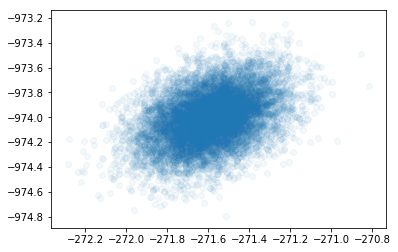

In [12]:
plt.scatter(sample[:,2],sample[:,3],alpha=0.05)
plt.show()

In [13]:
DminMC = np.zeros([n_source,sample_size])
Dmin2015MC = np.zeros([n_source,sample_size])

lensMC = np.zeros([n_source,sample_size,2,nt])
sourceMC = np.zeros([n_source,sample_size,2,nt])
distanceMC = np.zeros([n_source,sample_size,nt])
R_EMC  = np.zeros([n_source,sample_size])
mag_factorMC = np.zeros([n_source,sample_size,nt])
mag_factor_netMC = np.zeros([n_source,sample_size,nt])

c = 0

for j in source_indices:
        
    # get alignments, distances, magnifications
    
    lens, source, distance, R_E, mag_factor = get_alignments(sample,sampleSource[c,:,:],time,Mstar,Earth,s[i]['ra'],
                                                            s[i]['dec'])
        
    lensMC[c,:,:,:] = lens
    sourceMC[c,:,:,:] = source
    distanceMC[c,:,:] = distance
    R_EMC[c,:] = R_E
    mag_factorMC[c,:,:] = mag_factor
    mag_factor_netMC[c,:,:] = net_magnification(s[i]['phot_g_mean_mag'],results[i][j]['phot_g_mean_mag'],mag_factor)
    
    Dmin2015MC[c,:] = np.amin(distance[:,earlyIndex],1)
    DminMC[c,:] = np.amin(distance[:,lateIndex],1)

    c += 1
    
maxMag = np.amax(mag_factorMC,2)
maxMagNet = np.amax(mag_factor_netMC,2)
maxTime = np.argmax(mag_factorMC,2)

SolElongation = np.zeros([len(results[i]),sample_size])

c = 0

for j in source_indices:
    
    SolElongation[c,:] = SkyCoord(results[i][j]['ra']*u.deg,
                                  results[i][j]['dec']*u.deg,frame='icrs').separation(PosSol[maxTime[c]])
    c += 1

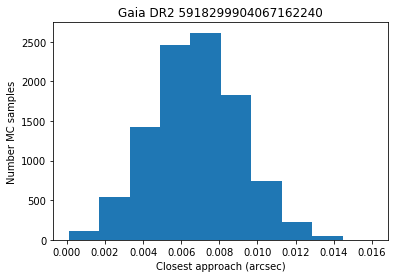

In [14]:
plt.hist(DminMC[source_index_plot,:])
plt.xlabel('Closest approach (arcsec)')
plt.ylabel('Number MC samples')
plt.title('Gaia DR2 '+str(s[i]['source_id']))

plt.savefig('plot_'+str(s[i]['source_id'])+'_dmin_arcsec.pdf')
#plt.show()

4593  out of  10000  within 1R_E


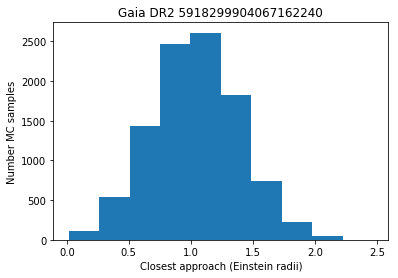

In [15]:
Nlt1RE = sum(DminMC[source_index_plot,:] < R_EMC[source_index_plot,:]/1000)
print(Nlt1RE,' out of ',sample_size,' within 1R_E')

plt.hist(DminMC[source_index_plot,:]/(R_EMC[source_index_plot,:]/1000))
plt.xlabel('Closest approach (Einstein radii)')
plt.ylabel('Number MC samples')
plt.title('Gaia DR2 '+str(s[i]['source_id']))

plt.savefig('plot_'+str(s[i]['source_id'])+'_dmin_RE.pdf')
#plt.show()

0 Gaia DR2  5918299904067162240 N sources:  11
Source               V mag                 Dmin
5918299908365843840 13.903836 0.006771865449416149 +/- 0.0022809515169483732
 
 


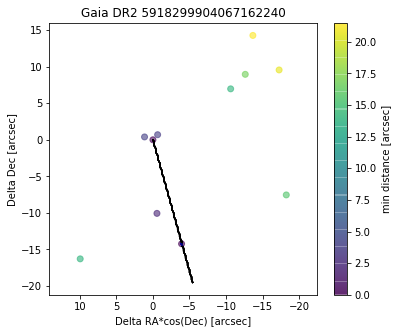

In [16]:

print(i,'Gaia DR2 ',s[i]['source_id'],
     'N sources: ',len(results[i]))
print('Source               V mag                 Dmin')
#print(s[i]['source_id'],s[i]['phot_g_mean_mag'],' 0.0')
c = 0
for j in source_indices:
    print(results[i][j]['source_id'],results[i][j]['phot_g_mean_mag'],np.mean(DminMC[c,:]),'+/-',np.std(DminMC[c,:]))
    c += 1
    
print(' ')
print(' ')

plt.figure(figsize=[6,5])
plt.scatter(dRASourceNom[i],dDecSourceNom[i],c=DminNom[i],alpha=0.6)

#for k in range(100):
#        plt.plot(-lensMC[j,k,0,:],lensMC[j,k,1,:],alpha=0.05,c='k')
        
c = 0
for j in source_indices:
    for k in range(100):
        plt.plot(lensMC[c,k,0,:],lensMC[c,k,1,:],alpha=0.05,c='k')
        plt.plot(sourceMC[c,k,0,:],sourceMC[c,k,1,:],alpha=0.05,c='b')
    c += 1

#plt.plot(-dRALensNom[i],dDecLensNom[i],c='c')
    
plt.colorbar(label='min distance [arcsec]')

plt.xlabel("Delta RA*cos(Dec) [arcsec]")
plt.ylabel("Delta Dec [arcsec]")
plt.title('Gaia DR2 '+str(s[i]['source_id']))
plt.axis('equal')

plt.gca().invert_xaxis()

#plt.xlim(2,2.6)
#plt.ylim(-4,-3.4)

plt.savefig('plot_'+str(s[i]['source_id'])+'_radec.pdf')

#plt.show()

0 Gaia DR2  5918299904067162240 N sources:  11
Source               V mag                 Dmin
5918299908365843840 13.903836 0.006771865449416149 +/- 0.0022809515169483732
 
 


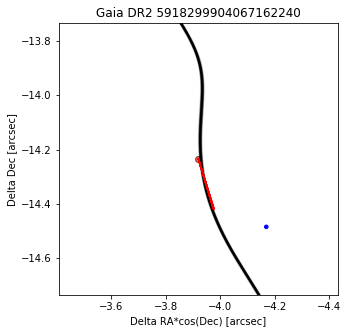

In [17]:
print(i,'Gaia DR2 ',s[i]['source_id'],
     'N sources: ',len(results[i]))
print('Source               V mag                 Dmin')
#print(s[i]['source_id'],s[i]['phot_g_mean_mag'],' 0.0')
c = 0
for j in source_indices:
    print(results[i][j]['source_id'],results[i][j]['phot_g_mean_mag'],np.mean(DminMC[c,:]),'+/-',np.std(DminMC[c,:]))
    c += 1
print(' ')
print(' ')

fig = plt.figure(figsize=[5,5])
plt.scatter(dRASourceNom[i],dDecSourceNom[i],c='r',alpha=0.6,edgecolor='k')

#for k in range(100):
#        plt.plot(-lensMC[j,k,0,:],lensMC[j,k,1,:],alpha=0.05,c='k')

c = 0
for j in source_indices:
    for k in range(100):
        plt.plot(lensMC[c,k,0,:],lensMC[c,k,1,:],alpha=0.05,c='k')
    for k in range(100):
        plt.plot(sourceMC[c,k,0,:],sourceMC[c,k,1,:],alpha=0.2,c='r')
    c += 1

#plt.plot(-dRALensNom[i],dDecLensNom[i],c='c')
    
#plt.colorbar(label='min distance [arcsec]')

EinsteinCircle = Circle((dRASourceNom[i][source_index]-0.25,dDecSourceNom[i][source_index]-0.25),
                        R_ENom[source_index]/1000,color='b')

ax = fig.gca()

ax.add_patch(EinsteinCircle)

plt.xlabel("Delta RA*cos(Dec) [arcsec]")
plt.ylabel("Delta Dec [arcsec]")
plt.title('Gaia DR2 '+str(s[i]['source_id']))
plt.axis('equal')

plt.xlim(dRASourceNom[i][source_index]+0.5,dRASourceNom[i][source_index]-0.5)
plt.ylim(dDecSourceNom[i][source_index]-0.5,dDecSourceNom[i][source_index]+0.5)

plt.savefig('plot_'+str(s[i]['source_id'])+'_radec_zoom.pdf')

#plt.show()

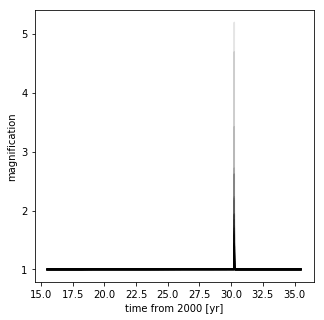

In [18]:
plt.figure(figsize=[5,5])

for j in range(100):
    plt.plot(time+15.5,mag_factorMC[source_index_plot,j,:],c='k',alpha=0.1)
plt.xlabel("time from 2000 [yr]")
plt.ylabel("magnification")

#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag.pdf')

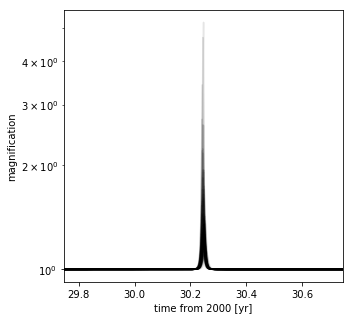

In [19]:
plt.figure(figsize=[5,5])

for j in range(100):
    plt.plot(time+15.5,mag_factorMC[source_index_plot,j,:],c='k',alpha=0.1)
plt.xlabel("time from 2000 [yr]")
plt.ylabel("magnification")

plt.xlim(np.median(maxTime[source_index_plot,:])*deltaT/(nt-1)+[15,16])
plt.yscale('log')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_zoom.pdf')

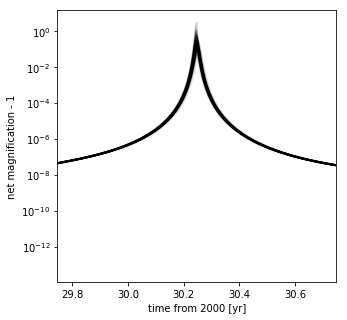

In [20]:
plt.figure(figsize=[5,5])

for j in range(100):
    plt.plot(time+15.5,mag_factor_netMC[source_index_plot,j,:],c='k',alpha=0.1)
plt.xlabel("time from 2000 [yr]")
plt.ylabel("net magnification - 1")

plt.xlim(np.median(maxTime[source_index_plot,:])*deltaT/(nt-1)+[15,16])
plt.yscale('log')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_net_zoom.pdf')

1.1619704614631248 1.3174013389898982 1.702279644615782


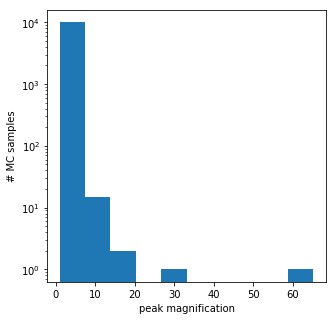

In [21]:
plt.figure(figsize=[5,5])

maxMag_dist = [np.percentile(maxMag[source_index_plot,:],16),np.median(maxMag[source_index_plot,:]),
               np.percentile(maxMag[source_index_plot,:],84)]

print(maxMag_dist[0],maxMag_dist[1],maxMag_dist[2])
plt.hist(maxMag[source_index_plot,:])
plt.yscale('log')
plt.xlabel('peak magnification')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_hist.pdf')

0.11609634882618572 0.2275052885347182 0.5033763678780756


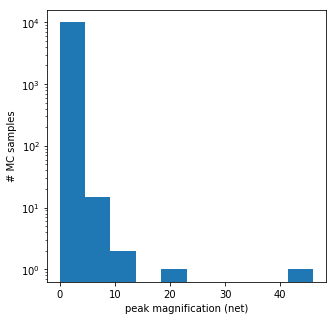

In [22]:
plt.figure(figsize=[5,5])

maxMagNet_dist = [np.percentile(maxMagNet[source_index_plot,:],16),np.median(maxMagNet[source_index_plot,:]),
                  np.percentile(maxMagNet[source_index_plot,:],84)]

print(maxMagNet_dist[0],maxMagNet_dist[1],maxMagNet_dist[2])
plt.hist(maxMagNet[source_index_plot,:])
plt.yscale('log')
plt.xlabel('peak magnification (net)')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_net_hist.pdf')

Median and 1-sigma confidence on Tmax:
2030-03-31
2030-04-01
2030-04-02


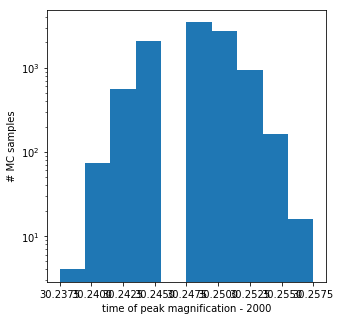

In [23]:
Tmax = astropy.time.Time(np.median(time[maxTime[source_index_plot,:]])+2015.5,format='jyear',out_subfmt='date')
Tmaxm= astropy.time.Time(np.percentile(time[maxTime[source_index_plot,:]],16)+2015.5,format='jyear',out_subfmt='date')
Tmaxp= astropy.time.Time(np.percentile(time[maxTime[source_index_plot,:]],84)+2015.5,format='jyear',out_subfmt='date')

Tmax.format = 'iso'
Tmaxm.format= 'iso'
Tmaxp.format= 'iso'

plt.figure(figsize=[5,5])

print('Median and 1-sigma confidence on Tmax:')
print(Tmaxm)
print(Tmax)
print(Tmaxp)
plt.hist(time[maxTime[source_index_plot,:]]+15.5)
plt.yscale('log')
plt.xlabel('time of peak magnification - 2000')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_tmax_hist.pdf')

Solar Elongation at peak magnification: 99.70064821954786 +/- 0.8319974656145358 degrees


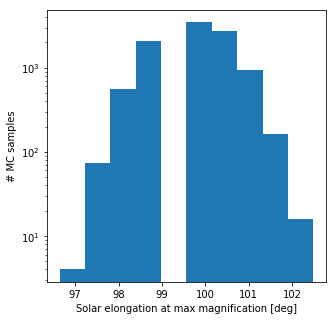

In [24]:
plt.figure(figsize=[5,5])

print('Solar Elongation at peak magnification: '+str(np.mean(SolElongation[source_index_plot,:]))+
      ' +/- '+str(np.std(SolElongation[source_index_plot,:]))+' degrees')
plt.hist(SolElongation[source_index_plot,:])
plt.yscale('log')
plt.xlabel('Solar elongation at max magnification [deg]')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_sol_elong_hist.pdf')

Magnification of source > 1.01 for 12.78375 13.696875  13.696875 days


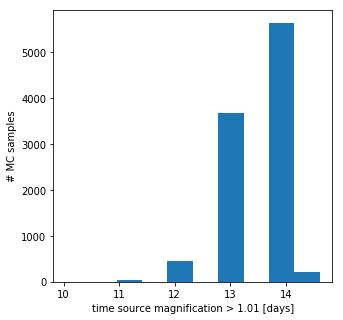

In [25]:
plt.figure(figsize=[5,5])
duration = np.sum(mag_factorMC[source_index_plot,:,:] > 1.01,1)*deltaT*365.25 / (nt-1)
#remove those with no magnification
duration = duration[np.nonzero(duration)]

if duration.size > 0:
    duration_dist = [np.percentile(duration,16),np.median(duration),np.percentile(duration,84)]
else:
    duration_dist = [0,0,0]
print('Magnification of source > 1.01 for '+str(duration_dist[0])+' '+str(duration_dist[1])+
      '  '+str(duration_dist[2])+' days')
plt.hist(duration)
plt.xlabel('time source magnification > 1.01 [days]')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_hist.pdf')

Net magnification > 1 + 1e-4 for 42.916875 42.916875  43.83 days


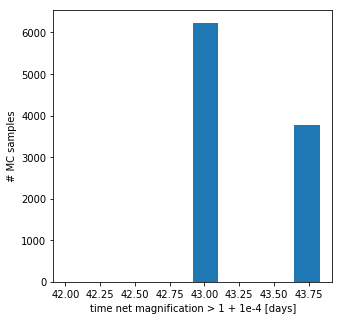

In [26]:
plt.figure(figsize=[5,5])
duration_net = np.sum(mag_factor_netMC[source_index_plot,:,:] > 1e-4,1)*deltaT*365.25 / (nt-1)
duration_net = duration_net[np.nonzero(duration_net)]

if duration_net.size > 0:
    duration_net_dist = [np.percentile(duration_net,16),np.median(duration_net),np.percentile(duration_net,84)]
else:
    duration_net_dist = [0,0,0]
print('Net magnification > 1 + 1e-4 for '+str(duration_net_dist[0])+' '+str(duration_net_dist[1])+
      '  '+str(duration_net_dist[2])+' days')
plt.hist(duration_net)
plt.xlabel('time net magnification > 1 + 1e-4 [days]')
plt.ylabel('# MC samples')
#plt.show()
plt.savefig('plot_'+str(s[i]['source_id'])+'_mag_net_hist.pdf')

In [27]:
print(results[0]['source_id'][0],
      results[0]['phot_g_mean_mag'][0],
      results[0]['ra'][0],
      results[0]['dec'][0],
      results[0]['pmra'][0],
      results[0]['pmdec'][0],
      results[0]['parallax'][0],
      results[0]['teff_percentile_lower'][0],
      results[0]['teff_val'][0],
      results[0]['teff_percentile_upper'][0],
      Mlens[0],Mlens[1],Mlens[2],
      Llens[0],Llens[1],Llens[2],
      RHZ[0],RHZ[1],RHZ[2],
      RE_Final[0],RE_Final[1],RE_Final[2],
      RE_Final[0]/s[0]['parallax'],RE_Final[1]/s[0]['parallax'],RE_Final[2]/s[0]['parallax'],
      results[0]['source_id'][source_index],
      results[0]['phot_g_mean_mag'][source_index],
      results[0]['ra'][source_index],
      results[0]['dec'][source_index],
      results[0]['pmra'][source_index],
      results[0]['pmdec'][source_index],
      results[0]['parallax'][source_index],
      Nlt1RE/sample_size*100,
      np.percentile(DminMC[source_index_plot,:],16),
      np.median(DminMC[source_index_plot,:]),
      np.percentile(DminMC[source_index_plot,:],84),
      maxMag_dist[0],maxMag_dist[1],maxMag_dist[2],
      maxMagNet_dist[0],maxMagNet_dist[1],maxMagNet_dist[2],
      Tmaxm,Tmax,Tmaxp,
      duration_dist[0],duration_dist[1],duration_dist[2],
      duration_net_dist[0],duration_net_dist[1],duration_net_dist[2],
      np.percentile(SolElongation[source_index_plot,:],16),
      np.median(SolElongation[source_index_plot,:]),
      np.percentile(SolElongation[source_index_plot,:],84))
      

5918299904067162240 14.911963 269.66258508708955 -58.66025011801147 -271.5888182602594 -974.007378577683 52.23554480051848 3435.0 3612.63 4024.7102 0.10367490299416464 0.10026750174703446 0.09968222058897772 0.0007391356872579637 0.0006776246853874626 0.0006673885388235476 0.027187049991824485 0.026031225199507277 0.025833864186829418 6.627041440356509 6.517228749087569 6.498179736217506 0.12686842772798512 0.12476616782645063 0.124401492528379 5918299908365843840 13.903836 269.6604914582257 -58.664204148934374 -2.772386925876788 -9.12116973060692 0.21968357730270346 45.93 0.004475098908369837 0.006751033041077354 0.009044097780782169 1.1619704614631248 1.3174013389898982 1.702279644615782 0.11609634882618572 0.2275052885347182 0.5033763678780756 2030-03-31 2030-04-01 2030-04-02 12.78375 13.696875 13.696875 42.916875 42.916875 43.83 98.84297447198487 99.57466024618823 100.30519011248352


In [28]:
results[0]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.0,1635721458409799680,Gaia DR2 5918299904067162240,5918299904067162240,754397272,2015.5,269.66258508708955,0.10032057987911441,-58.66025011801147,0.12360607828689704,52.23554480051848,0.11887178289025528,439.4276,-271.5888182602594,0.17388884296739282,-974.007378577683,0.20927141262375173,0.4851471,-0.022608543,-0.4772825,-0.44454998,-0.3580444,-0.28805673,-0.7028395,-0.24908072,0.13088758,0.38764167,160,0,160,0,25.594463,1180.8478,0.658155423281076,49.1384596602811,31,False,2.0791538,1.1786776368824459,0.02403866460531993,0.09740616,18,11,0.23323433,0,19,False,166,20443.760620334582,17.10770959117759,1195.0028,14.911963,18,1791.4576578074934,51.159639810175825,35.01701,17.218372,18,32527.55418413129,94.11436144640591,345.61734,13.481292,1.6787034,0,3.7370806,2.306409,1.4306717,--,--,0,--,--,--,NOT_AVAILABLE,334.8081297180862,-16.485773410505203,269.7851901971518,-35.22122086991326,100001,3612.63,3435.0,4024.7102,0.055,0.0,0.3426,0.035,0.0,0.182,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=5918299904067162240,--
0.0002634372756432668,1635721458409799680,Gaia DR2 5918299908359752960,5918299908359752960,447164595,2015.5,269.6622414759902,10.080946201892301,-58.66005657331985,7.05